# Comparing two means: Unpaired t Test

## Data visualization

In [67]:
import numpy as np
from scipy import stats
import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
# data from Table 30.1 (page 295)
old = np.array([20.8, 2.8, 50, 33.3, 29.4, 38.9, 29.4, 52.6, 14.3])
young=np.array([45.5, 55, 60.7, 61.5, 61.1, 65.5, 42.9, 37.5])

In [38]:
k2, pval = stats.normaltest(old)
print('old', f"D'Agostino-Pearson omnibus K2={k2:.2f}", f"p-value={pval:.3f}", sep='\t')

k2, pval = stats.normaltest(young)
print('young', f"D'Agostino-Pearson omnibus K2={k2:.2f}", f"p-value={pval:.3f}", sep='\t')


tstat, pval = stats.shapiro(old)
print('old', "Shapiro-Wilk's normality test p-value", round(pval, 3), sep='\t')

tstat, pval = stats.shapiro(young)
print('young', "Shapiro-Wilk's normality test p-value", round(pval, 3), sep='\t')
# if the P value from a normality test is large, the data are not inconsistent with a Gaussian distribution 

old	D'Agostino-Pearson omnibus K2=0.11	p-value=0.947
young	D'Agostino-Pearson omnibus K2=1.75	p-value=0.418
old	Shapiro-Wilk's normality test p-value	0.9
young	Shapiro-Wilk's normality test p-value	0.238


In [68]:
pg.normality(old)

,W,pval,normal
0,0.970675,0.900443,True


In [69]:
pg.normality(young)

,W,pval,normal
0,0.890741,0.23777,True


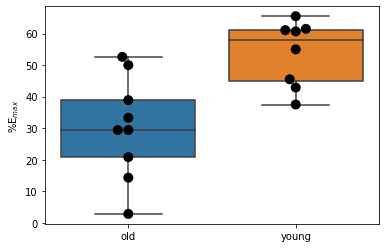

In [33]:
sns.boxplot(data=[old, young])
sns.swarmplot(data=[old, young], color='black', size=10)
plt.ylabel(r"%E$_{max}$")
plt.xticks([0,1], ['old', 'young']);

## Description of the data

### Unpaired two-sample T test using scipy

In [140]:
stats.ttest_ind(young, old, equal_var=False) # also called the Welch's t-test

Ttest_indResult(statistic=3.6242456851120375, pvalue=0.002828426914881655)

In [124]:
stats.ttest_ind(young, old, equal_var=True)

Ttest_indResult(statistic=3.531487707161938, pvalue=0.0030218492023012695)

### Unpaired (independent) two-sample T test using pingouin

pingouin just calls the scipy.ttest_ind method

In [82]:
pg.ttest(young, old, correction=False) # specify whether or not to correct for unequal variances using Welch separate variances T-test

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,3.531488,15,two-sided,0.003022,"[9.33, 37.76]",1.715995,12.56,0.909532


Because the 95% CI of the mean difference does not include zero, we are 95% confident that the mean response in old individuals is less than the mean response in young ones.

In [6]:
stats.describe(old)

DescribeResult(nobs=9, minmax=(2.8, 52.6), mean=30.16666666666667, variance=259.0375, skewness=-0.17569385392311104, kurtosis=-0.8080848898945967)

In [7]:
stats.describe(young)

DescribeResult(nobs=8, minmax=(37.5, 65.5), mean=53.7125, variance=107.4069642857143, skewness=-0.4421628669270582, kurtosis=-1.3632352105713499)

In [119]:
mean_diff = np.mean(young) - np.mean(old)
print(f"mean difference = {mean_diff:5.3f}")

mean difference = 23.546


### Testing the assumption of equal variances (_homoscedasticity_)

In [49]:
ratio_var = np.std(old, ddof=1) / np.std(young, ddof=1) # ratio of the variances of the two groups
print(f"The old individuals have an SD {ratio_var:.2f} times larger than that of young individuals.")

F_ratio = ratio_var**2
print(f"F ratio = {F_ratio:5.3f}")

p_val = 2 * (1 - stats.f.cdf(F_ratio, len(old)-1, len(young)-1)) # for two-sided (see Crawley, the R book, p.355)
print(f"P value for the F-test of equal variance={p_val:.4f}")

The old individuals have an SD 1.55 times larger than that of young individuals.
F ratio = 2.412
P value for the F-test of equal variance=0.2631


If H0 of equal variances were true, there would be a 26% chance that random sampling would result in this large discrepancy between the two SD values as observed here (or larger still).

In [66]:
pg.homoscedasticity([young, old], method="bartlett")

,T,pval,equal_var
bartlett,1.290011,0.256046,True


### t ratio

The P value is computed from the _t ratio_ which is computed from the difference between the two sample means and the SD and sample size of each group, such as

$$t=(\overline{x} - \overline{y}) / (\frac{s_x^2}{n_x} + \frac{s_y^2}{n_y})$$

where $s_x^2$ and $s_y^2$ are the sample variances (squared standard deviation).

Thus $t=\frac{\overline{x_d}}{s_{\overline{x_d}}}$ and $s_{\overline{x_d}} = \frac{s_d}{\sqrt n}$, where $\overline{x_d}$ is the sample mean of the differences between the two samples, $n$ is the number of observations (sample size), $s_d$ is the sample standard deviation of the differences and $s_{\overline{x_d}}$ is the estimated standard error of the mean of the differences. The P value is then calculated using a T-distribution with n−1 degrees of freedom.

In [129]:
se_old = np.std(old, ddof=1)     / len(old)  **.5 # equivalent to stats.sem(old)
se_young = np.std(young, ddof=1) / len(young)**.5 # equivalent to stats.sem(young)
se_diff = (se_old**2 + se_young**2)**.5

In [138]:
t_ratio = mean_diff / se_diff
print(f"t ratio = {t_ratio:.4f}")

t ratio = 3.6242


This gives the t ratio as for unequal variances!

For equal variance: $$t = \frac{\overline{x} - \overline{y}}{\frac{(n_x - 1)s_x^2 + (n_y - 1)s_y^2}{n_x+n_y-2}\times \sqrt{1/n_x +1/n_y}}$$

In [145]:
Df = len(old) + len(young) - 2 # this is true only for equal variances, otherwise use Welch–Satterthwaite method

t_ratio = mean_diff / ( (1/len(old) + 1/len(young))**0.5 *
    (((len(old) - 1) * np.std(old, ddof=1)**2 + (len(young) - 1) * np.std(young, ddof=1)**2 ) / Df)
)

print(f"t ratio computed for equal variances = {t_ratio:.3f}")

t ratio computed for equal variances = 0.257


In [142]:
t_ = stats.t(df=Df).ppf((1+.95)/2) # two-tailed
CI_diff_mean = (mean_diff - t_*SEM_mean_diff, mean_diff + t_*SEM_mean_diff)

In [148]:
print(f"CI of the mean difference {mean_diff:.2f} is {CI_diff_mean[0]:.2f} - ")

CI of the mean difference 23.55 is 9.70


##### Computing CI and P value with bootstraping

In [22]:
bs_old = np.array([np.mean(np.random.choice(old, size=len(old))) for _ in range(10000)])
bs_young= np.array([np.mean(np.random.choice(young,size=len(young))) for _ in range(10000)])

In [28]:
bs_mean_diff = bs_young - bs_old

In [29]:
CI_mean_diff_bs = np.percentile(bs_mean_diff, [2.5, 97.5])
print(f"mean difference using bootstraping = {np.mean(bs_mean_diff):5.2f}")
print(f"CI of the mean difference using bootstraping = {CI_mean_diff_bs}")

mean difference using bootstraping = 23.61
CI of the mean difference using bootstraping = [11.57413194 35.66055556]


In [33]:
# now we test the H0 hypothesis that both sets comes from the same population, same mean
combined_mean = np.mean(np.concatenate([old, young]))

In [35]:
young_shifted = young - np.mean(young) + combined_mean
old_shifted = old - np.mean(old) + combined_mean

In [67]:
bs_shifted_old = np.array([np.mean(np.random.choice(
    old_shifted, size=len(old))) for _ in range(10000)])
bs_shifted_young = np.array([np.mean(np.random.choice(
    young_shifted, size=len(old))) for _ in range(10000)])
bs_diff_shifted = bs_shifted_young - bs_shifter_old

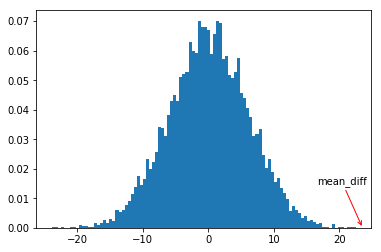

In [72]:
plt.hist(bs_diff_shifted, density=True, bins=100)
#plt.vlines(mean_diff, 0, .01, color='red', linestyles='--')
plt.annotate('mean_diff', xy=(mean_diff, 0), xytext=(mean_diff-7, .015),
            arrowprops={'arrowstyle': '->', 'color': 'red'});

In [73]:
P_value_bs = np.sum(bs_diff_shifted >= mean_diff) / len(bs_diff_shifted)
print(f"P value obtained using bootstraping = {P_value_bs:7.6f}")

P value obtained using bootstraping = 0.000000
